In [1]:
import pandas as pd
from preprocess import Audio_Processor
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np
from data_utils import enumerate_strings
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

#Styling
import seaborn as sns
sns.set(style="whitegrid")

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR/4)
overlap = int(SR/8)

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Preprocessing
Just MFCC were sufficient in previous work.
13 coefficients together with first and second derivatives and remove first energy component.
Should yield vector of 38 features per time frame.

In [4]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {
    'dog': 0,
    'rooster': 0,
    'pig': 0,
    'cow': 0,
    'frog': 0,
    'cat': 0,
    'hen': 0,
    'insects': 0,
    'sheep': 0,
    'crow': 0,
    'rain': 1,
    'sea_waves': 1,
    'crackling_fire': 1,
    'crickets': 0,
    'chirping_birds': 0,
    'water_drops': 1,
    'wind': 1,
    'pouring_water': 1,
    'toilet_flush': 1,
    'thunderstorm': 1,
    'crying_baby': 0,
    'sneezing': 0,
    'clapping': 1,
    'breathing': 0,
    'coughing': 0,
    'footsteps': 1,
    'laughing': 0,
    'brushing_teeth': 1,
    'snoring': 0,
    'drinking_sipping': 1,
    'door_wood_knock': 1,
    'mouse_click': 1,
    'keyboard_typing': 1,
    'door_wood_creaks': 1,
    'can_opening': 1,
    'washing_machine': 1,
    'vacuum_cleaner': 1,
    'clock_alarm': 1,
    'clock_tick': 1,
    'glass_breaking':1,
    'helicopter': 1,
    'chainsaw': 1,
    'siren': 1,
    'car_horn': 1,
    'engine': 1,
    'train': 1,
    'church_bells': 1,
    'airplane': 1,
    'fireworks': 1,
    'hand_saw': 1,
}
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

# Some statistics
We have a lot of negatives when compared to positives when training shallow nets, if improving accuracy it will naturally gravitate toward guessing 0
### Distribution of Samples

In [5]:
block_tries = {
    "blocksize": [int(SR/4), int(SR/2), int(SR), int(SR * 2), int(SR * 5)],
    "overlap": [int(SR/8), int(SR/4), int(SR/2), int(SR), 0]
              }
h_class_unique = []
l_class_unique = []
for i in range(len(block_tries['blocksize'])):
    df = ps.preprocess_fold(dataset,
                           kind='mfcc',
                           blocksize=block_tries['blocksize'][i],
                           overlap=block_tries['overlap'][i])
    grp = df.groupby('target')
    l_class_unique.append(
        pd.DataFrame(
            grp.count()
        ).reset_index()
    )
    l_class_unique[-1]['blocksize'] = block_tries['blocksize'][i]
    grp = df.groupby('h_target')
    h_class_unique.append(
        pd.DataFrame(
            grp.count()
        ).reset_index()
    )
    h_class_unique[-1]['blocksize'] = block_tries['blocksize'][i]  

In [6]:
l_class_unique[0].reset_index()

,index,target,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,...,sflat_mean,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,blocksize
0,0,0,569,569,569,569,569,569,569,569,...,569,569,569,569,569,569,569,569,569,4000
1,1,1,591,591,591,591,591,591,591,591,...,591,591,591,591,591,591,591,591,591,4000
2,2,2,1174,1174,1174,1174,1174,1174,1174,1174,...,1174,1174,1174,1174,1174,1174,1174,1174,1174,4000
3,3,3,1099,1099,1099,1099,1099,1099,1099,1099,...,1099,1099,1099,1099,1099,1099,1099,1099,1099,4000
4,4,4,1193,1193,1193,1193,1193,1193,1193,1193,...,1193,1193,1193,1193,1193,1193,1193,1193,1193,4000
5,5,5,907,907,907,907,907,907,907,907,...,907,907,907,907,907,907,907,907,907,4000
6,6,6,1054,1054,1054,1054,1054,1054,1054,1054,...,1054,1054,1054,1054,1054,1054,1054,1054,1054,4000
7,7,7,1345,1345,1345,1345,1345,1345,1345,1345,...,1345,1345,1345,1345,1345,1345,1345,1345,1345,4000
8,8,8,1409,1409,1409,1409,1409,1409,1409,1409,...,1409,1409,1409,1409,1409,1409,1409,1409,1409,4000
9,9,9,1196,1196,1196,1196,1196,1196,1196,1196,...,1196,1196,1196,1196,1196,1196,1196,1196,1196,4000


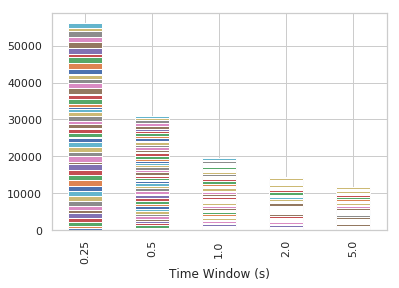

In [14]:
l_class = pd.concat(l_class_unique, ignore_index=True)
l_class['Time Window (s)'] = l_class['blocksize'] / SR
l_class = l_class[['Time Window (s)', 'target', 'mfcc_2_std']]
l_class.columns = ['Time Window (s)', 'target', 'count']

l_class = l_class.pivot(index='Time Window (s)', columns='target', values='count')
l_class.plot.bar(stacked=True, legend=False)

Text(0, 0.5, 'Number of Samples')

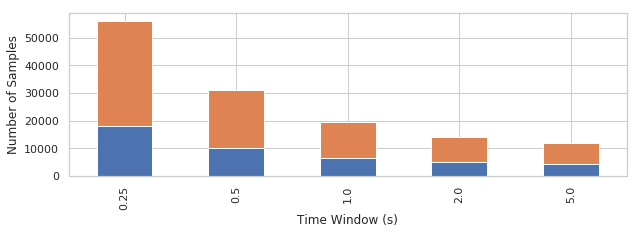

In [24]:
h_class = pd.concat(h_class_unique, ignore_index=True)
h_class['Time Window (s)'] = h_class['blocksize'] / SR

h_class = h_class[['Time Window (s)', 'h_target', 'mfcc_2_std']]
h_class.columns = ['Time Window (s)', 'h_target', 'count']

h_class = h_class.pivot(index='Time Window (s)', columns='h_target', values='count')
ax = h_class.plot.bar(stacked=True, figsize=(10,3), legend=False)
ax.set_ylabel('Number of Samples')